<a href="https://colab.research.google.com/github/rgumi/SentimentClassifier/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install -qq transformers tqdm

In [19]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.utils import class_weight
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# Config and data objects

In [20]:
MAX_LEN = 120
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
DROPOUT = 0.3
WARMUP_STEPS = 0
LEARNING_RATE= 5e-5
MODEL_PATH = "/content/drive/My Drive/SentimentAnalysis/model.bin"
TRAINING_FILE = "/content/drive/My Drive/SentimentAnalysis/SB10k-corpus.csv"
PRE_TRAINED_MODEL_NAME = 'bert-base-german-cased'
CLASS_NAMES = ['negative', 'neutral', 'positive']
TOKENIZER = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [21]:
class BERTDataset:
    def __init__(self, tweet, target, tokenizer, max_len):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "tweet_text": tweet,
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.target[item], dtype=torch.long),
        }


In [22]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=DROPOUT)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, ids, mask, token_type_ids):
    _, pooled_output = self.bert(
      input_ids=ids,
      attention_mask=mask,
      token_type_ids=token_type_ids
    )
    output = self.drop(pooled_output)
    return self.out(output)

# Preprocess

In [23]:
def get_class(polarity):
  # just roughly group the polarity floats together
  
  if polarity > 0:
    # positive class
    return 2
  if polarity < 0:
    # negative class
    return 0
  # neutral class
  return 1

def convert_class(polarity):
  # just roughly group the polarity floats together
  
  if polarity == "positive":
    # positive class
    return 2
  if polarity == "negative":
    # negative class
    return 0
  # neutral class
  return 1

In [24]:
# https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing#Removal-of-Emojis
def remove_emoji(string):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string)

In [25]:
def replace_multi_ex_marks(txt):
  return re.sub(pattern=r'!{2,}', repl=' multiExclamation', string=txt)

def replace_multi_q_marks(txt):
  return re.sub(pattern=r'\?{2,}', repl=' multiQuestion', string=txt)

def replace_multi_dots(txt):
  return re.sub(pattern=r'\.{2,}', repl='', string=txt)

def remove_multi_marks(txt):
  return re.sub(pattern=r'[\.!\?]{2,}', repl='', string=txt)

def remove_at_user(txt):
  return re.sub(pattern=r'@', repl='', string=txt)

def remove_hashtags(txt):
  return re.sub(pattern=r'#', repl='', string=txt)

def replace_pos_emojis(txt):
  return re.sub(pattern=r':\)|;\)|:-\)|;-\)', repl=' posEmoji ', string=txt)

def replace_neg_emojis(txt):
  return re.sub(pattern=r':\(|;\(|:-\(|;-\(|:-/|:/', repl=' negEmoji ', string=txt)

def remove_pos_emojis(txt):
  return re.sub(pattern=r':\)|;\)|:-\)|;-\)', repl='', string=txt)

def remove_neg_emojis(txt):
  return re.sub(pattern=r':\(|;\(|:-\(|;-\(|:-/|:/', repl='', string=txt)

In [26]:
def preprocess(txt):
  functions = [remove_multi_marks, remove_at_user, remove_hashtags]

  for func in functions:
    txt = func(txt)
  return txt

# Modeling

In [27]:
def loss_fn(outputs, targets):
    #return nn.BCEWithLogitsLoss()(outputs, targets)
    return nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model.train()
  losses = []
  correct_predictions = 0

  for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.long)

      outputs = model(
          ids=ids, 
          mask=mask, 
          token_type_ids=token_type_ids
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()

      #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      
  return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  losses = []
  correct_predictions = 0


  with torch.no_grad():
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.long)

      outputs = model(
          ids=ids, 
          mask=mask, 
          token_type_ids=token_type_ids
      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    # accuracy = n_correct / n_all
    return correct_predictions.double() / n_examples, np.mean(losses)


In [28]:
def run(model, device, train_data, valid_data, max_len, tokenizer, 
        train_batch_size, valid_batch_size, warmup_steps, lr):
  
  model.to(device)

  train_dataset = BERTDataset(
      tweet=df_train.message.values, target=df_train.sentiment.values,
      tokenizer=tokenizer, max_len=max_len
  )

  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=train_batch_size, num_workers=4
  )

  valid_dataset = BERTDataset(
      tweet=df_valid.message.values, target=df_valid.sentiment.values,
      tokenizer=tokenizer, max_len=max_len
  )

  valid_data_loader = torch.utils.data.DataLoader(
      valid_dataset, batch_size=valid_batch_size, num_workers=1
  )
  
  class_weights = torch.FloatTensor(
    class_weight.compute_class_weight(
        'balanced', 
        np.unique(df_train.sentiment), 
        df_train.sentiment)
  )
  loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
  #loss_fn = nn.CrossEntropyLoss().to(device)
  
  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
  optimizer = AdamW(optimizer_parameters, lr=lr)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_train_steps
  )

  # run on multiple gpus
  model = nn.DataParallel(model)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    valid_acc, valid_loss = eval_model(
      model,
      valid_data_loader,
      loss_fn, 
      device, 
      len(df_valid)
    )

    print(f'Val   loss {valid_loss} accuracy {valid_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['valid_acc'].append(valid_acc)
    history['valid_loss'].append(valid_loss)

    if valid_acc > best_accuracy:
        torch.save(model.state_dict(), MODEL_PATH)
        best_accuracy = valid_acc

  plt.plot(history['train_acc'], label='train accuracy')
  plt.plot(history['valid_acc'], label='validation accuracy')

  plt.title('Training history')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.ylim([0, 1]);

In [29]:
def get_predictions(model, data, device, batch_size, max_len, tokenizer):
  model = model.eval()
  model.to(device)

  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  dataset = BERTDataset(
      tweet=data.message.values, target=data.sentiment.values,
      tokenizer=tokenizer, max_len=max_len
  )

  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, num_workers=4
  )

  with torch.no_grad():

    for d in data_loader:
      text = d["tweet_text"]
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.long)

      outputs = model(
          ids=ids, 
          mask=mask, 
          token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      # convert vector to vector with the sum of 1 
      # represents the distribution of probability of the classes
      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(text)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [30]:
model = SentimentClassifier(len(CLASS_NAMES))

dfx = pd.read_csv(TRAINING_FILE).fillna("none")

dfx.sentiment= dfx.sentiment.apply(convert_class)
dfx.message = dfx.message.apply(preprocess)

df_train, df_valid_test = train_test_split(
    dfx, test_size=0.2, random_state=42, stratify=dfx.sentiment.values
)

df_valid, df_test = train_test_split(
    df_valid_test, test_size=0.5, random_state=42, stratify=df_valid_test.sentiment.values
)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(df_train.shape, df_valid.shape, df_test.shape)

(5270, 2) (659, 2) (659, 2)


Epoch 1/5
----------



Train loss 0.8607044555924156 accuracy 0.6419354838709678



Val   loss 0.7697726119132269 accuracy 0.6874051593323217

Epoch 2/5
----------



Train loss 0.5082723926414143 accuracy 0.7929791271347248



Val   loss 0.8026131434100015 accuracy 0.6995447647951442

Epoch 3/5
----------



Train loss 0.25612397162300166 accuracy 0.9015180265654649



Val   loss 1.0438396348839714 accuracy 0.708649468892261

Epoch 4/5
----------



Train loss 0.10901212248612534 accuracy 0.959203036053131



Val   loss 1.232680360476176 accuracy 0.7056145675265554

Epoch 5/5
----------



Train loss 0.045826910492597205 accuracy 0.9846299810246679



Val   loss 1.3704981264613925 accuracy 0.7298937784522004



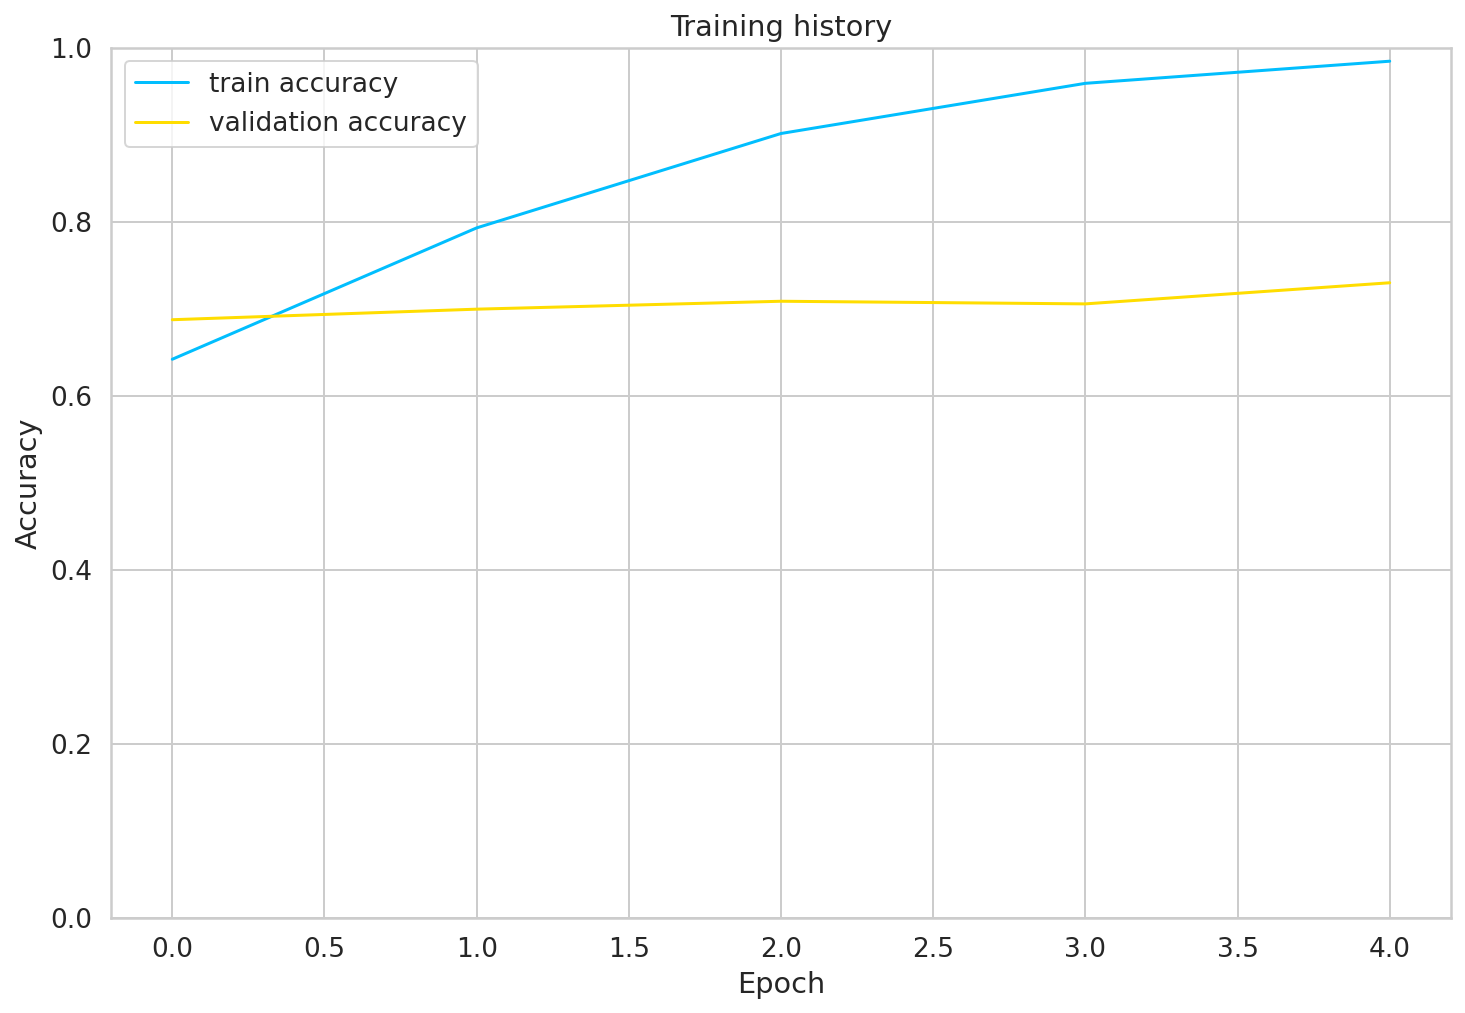

In [31]:
run(model, DEVICE, df_train, df_valid, MAX_LEN, TOKENIZER, 
    TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, WARMUP_STEPS, LEARNING_RATE)

In [32]:
# run model on test dataset to evaluate its performance
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  df_test,
  DEVICE,
  VALID_BATCH_SIZE,
  MAX_LEN,
  TOKENIZER
)

In [33]:
# https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    negative       0.53      0.51      0.52        99
     neutral       0.82      0.85      0.83       411
    positive       0.69      0.65      0.67       149

    accuracy                           0.75       659
   macro avg       0.68      0.67      0.67       659
weighted avg       0.75      0.75      0.75       659



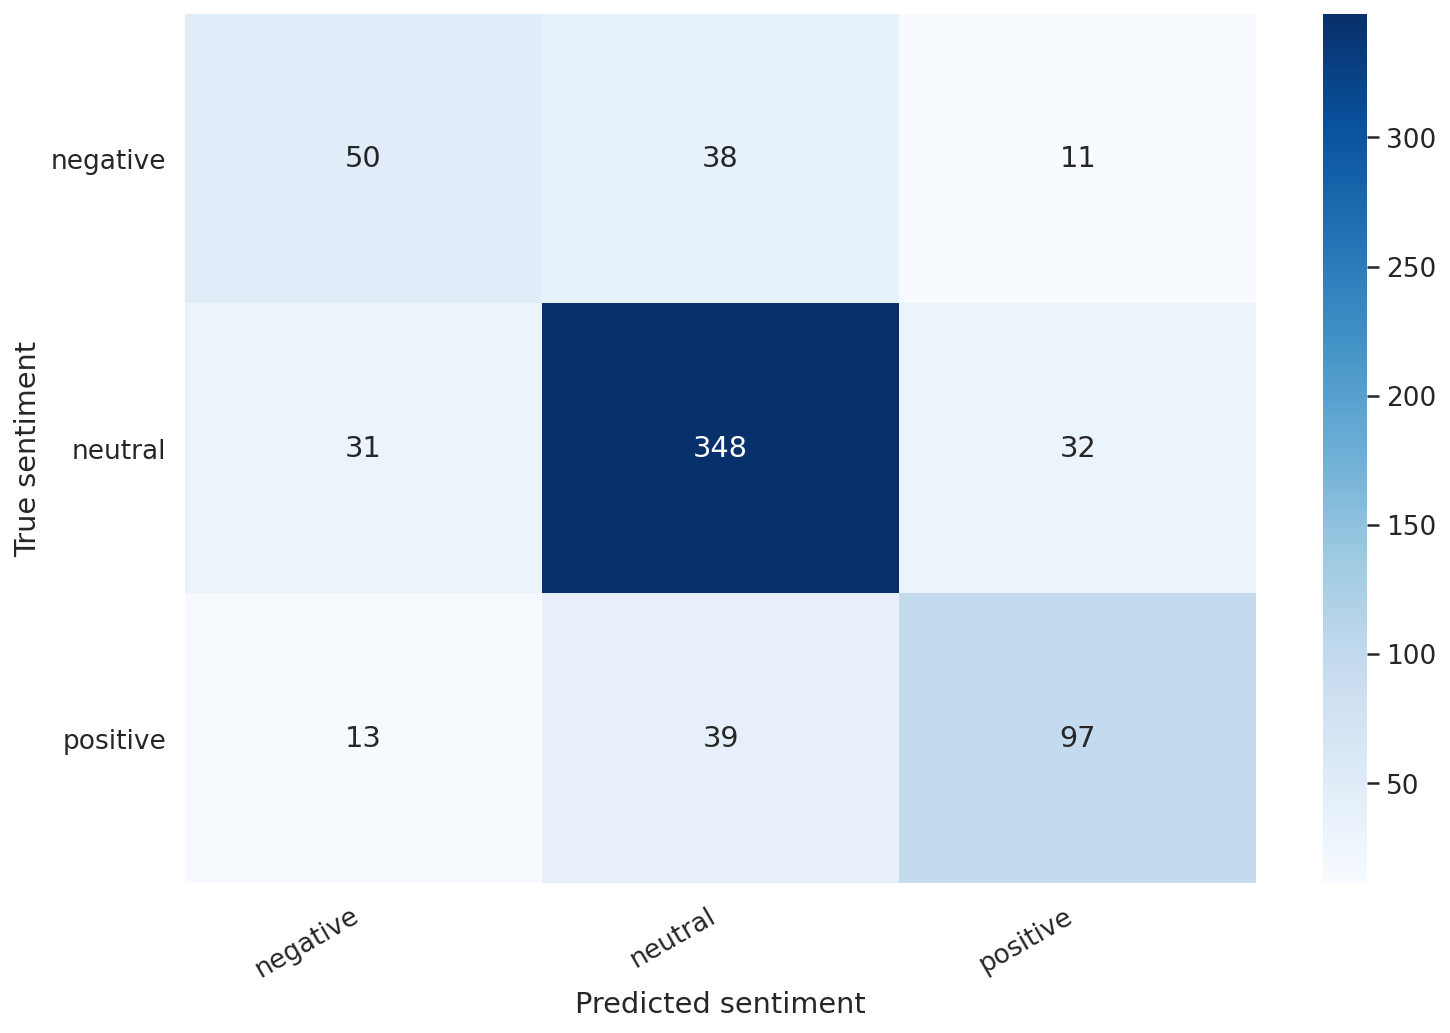

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)